VAEs dynamiques : https://arxiv.org/abs/2008.12595

# Training a Variational RNN

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import timeit
from IPython.display import clear_output

In [4]:
from libs.vrnn_lib_sprites import seed_everything, VRNN
from libs.vrnn_lib_sprites import loss_function, train
from libs.vrnn_lib_sprites import BetaLinearScheduler, BetaThresholdScheduler
from libs.vrnn_lib_sprites import plot_losses, sample_predictions

In [5]:
# Set seed for reproducibility
seed_everything(42)

In [9]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float32)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 3090
Total GPU Memory: 23.7 GB


# Modèle

### Variational RNN :

The full factorization of $p(z_{1:T}, x_{1:T})$ is used:

\begin{align}
p(z_{1:T}, x_{1:T}) &= \prod_{t=1}^T p(z_t, x_t \vert z_{1:t-1}, x_{1:t-1}) \\
&= \prod_{t=1}^T p_{\theta_x}(x_t \vert x_{1:t-1}, z_{1:t}) p_{\theta_z}(z_t \vert z_{1:t-1}, x_{1:t-1}) \\
\end{align}

Where the two distributions $p_{\theta_z}$ and $p_{\theta_x}$ are Gaussians :

\begin{align}

p_{\theta_x}(x_t \vert x_{1:t-1}, z_{1:t}) &= \mathcal{N}(x_t \vert \mu_{\theta_x}(\overrightarrow{g}_{t-1}, h_{t}), \text{diag}(\sigma_{\theta_x}^{2}(\overrightarrow{g}_{t-1}, h_{t}))) \\
d_x(\overrightarrow{g}_{t-1}, h_{t}) &= [ \mu_{\theta_x}(\overrightarrow{g}_{t-1}, h_{t}), \sigma_{\theta_x}(\overrightarrow{g}_{t-1}, h_{t}) ] \\

p_{\theta_z}(z_t \vert z_{1:t-1}, x_{1:t-1}) &= \mathcal{N}(z_t \vert \mu_{\theta_z}(\overrightarrow{g}_{t-1}, h_{t-1}), \text{diag}(\sigma_{\theta_z}^{2}(\overrightarrow{g}_{t-1}, h_{t-1}))) \\
d_z(\overrightarrow{g}_{t-1}, h_{t-1}) &= [ \mu_{\theta_z}(\overrightarrow{g}_{t-1}, h_{t-1}), \sigma_{\theta_z}(\overrightarrow{g}_{t-1}, h_{t-1}) ] \\

\end{align}

où $d_x, d_z$ sont des MLP,

et où $h_t = \text{LSTM}(z_t, h_{t-1})$ est un forward LSTM qui encode $z_{1:t}$

et $\overrightarrow{g}_t = \text{LSTM}(x_t, \overrightarrow{g}_{t-1})$ est un forward LSTM qui encode $x_{1:t}$

### Modèle inférence

Le "true posterior" s'écrit :
\begin{align}
p_{\theta}(z_{1:T} \vert x_{1:T}) &= \prod_{t=1}^T p_{\theta} (z_t \vert z_{1:t-1}, x_{1:T} ) \\
\end{align}

où la première écriture est la stricte application de la chain rule.

On choisit comme approximation du posterior (=encodeur) une formulation calquée sur le vrai posterior :

\begin{align}
q_{\phi}(z_{1:T} \vert x_{1:T}) &= \prod_{t=1}^T q_{\phi} (z_{t} \vert z_{1:t-1}, x_{1:T}) \\
\end{align}

Et:
\begin{align}
q_{\phi} (z_{t} \vert z_{1:t-1}, x_{1:T}) &= \mathcal{N}(z_t \vert \mu_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}), \text{diag} (\sigma_{\phi}^2(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}))) \\
d_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}) &= [ \mu_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}), \sigma_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}) ]
\end{align}

où $d_{\phi}$ est un MLP, et

$\overleftarrow{g}_t = \text{LSTM}(x_t, \overleftarrow{g}_{t-1})$ est un backward LSTM qui encode $x_{t:T}$

# Implémentation de l'inférence

Il y a ici quelques choix d'implémentations différents de ceux du papier originel, et adapté au dataset **Sprites** :

- **trois** LSTMs distincts pour encoder $z_{1:t}$, $x_{1:t}$ et $x_{t:T}$

- CNN2D pour PreEncoder et PostDecoder

# Training

Le modèle s'entraîne en maximisant un ELBO, dont la formulation dans le cas du VRNN est:

\begin{align}
    \begin{split}
    \mathcal{L}(\theta, \phi; X) &= \sum_{t=1}^T  \mathbb{E}{q_{\phi}(z_{1:t} \vert x_{1:T})} \log{p_{\theta_x}(x_t \vert x_{1:t-1}, z_{1:t})} \\ &- \sum_{t=1}^T \mathbb{E}{q_{\phi}(z_{1:t-1} \vert x_{1:T})} \mathbb{KL}{q_{\phi}(z_t \vert z_{1:t-1}, x_{1:T})}{p_{\theta_z}(z_t \vert z_{1:t-1}, x_{1:t-1})} 
    \end{split}    
\end{align}
<!-- 
Les deux termes s'explicitent de la façon suivante (avec $D$ dimension de l'espace des observations) :

\begin{align}
p_{\theta_x}(x_t \vert z_t) &= \mathcal{N}(x_t \vert \mu_{\theta_x}(z_t), \text{diag}(\sigma_{\theta_x}^2(z_t))) \\
\log{p_{\theta_x}(x_t \vert z_t)} &= -\frac{D}{2} \log{2\pi} - \frac{1}{2}\log{\vert \text{diag}(\sigma_{\theta_x}^2(z_t)) \vert} - 
\frac{1}{2} \left[ (x_t - \mu_{\theta_x}(z_t))^T (\text{diag}(\sigma_{\theta_x}^2(z_t)))^{-1} (x_t - \mu_{\theta_x}(z_t)) \right] \\
&= - \frac{1}{2} \left( \sum_{i=1}^D \log{\sigma_{\theta_x}^2(z_t)}\vert_{i} + (x_t - \mu_{\theta_x}(z_t))^T \text{diag} \frac{1}{\sigma_{\theta_x}^2(z_t)} (x_t - \mu_{\theta_x}(z_t)) + D \log{2\pi} \right)
\end{align}

Et la KL entre les deux Gaussiennes:

\begin{align}
q_\phi(z_t \vert z_{t-1}, x_{t:T}) &= \mathcal{N}(z_t \vert \mu_{\phi}(g_t), \text{diag}(\sigma_\phi^2(g_t))) \\
p_{\theta_z}(z_t \vert z_{t-1}) &= \mathcal{N}(z_t \vert \mu_{\theta_z}(z_{t-1}), \text{diag}(\sigma_{\theta_z}^{2}(z_{t-1}))) \\
\end{align}

a une close form (avec $Z$ dimension de l'espace latent):

\begin{align}
\text{D}_{\text{KL}}(q_\phi \vert\vert p_{\theta_z}) &= \frac{1}{2} \left[ \text{Tr}(\text{diag}(\sigma_{\theta_z}^{2})^{-1} \text{diag}(\sigma_\phi^2) ) + (\mu_{\theta_z} - \mu_\phi)^T (\text{diag}(\sigma_{\theta_z}^{2})^{-1}) (\mu_{\theta_z} - \mu_\phi) +
\log{\frac{\vert \text{diag}(\sigma_{\theta_z}^{2})\vert}{\vert \text{diag}(\sigma_\phi^2) \vert} } \right] \\
&= \frac{1}{2}\left[ \sum_{i=1}^Z \log{\sigma_{\theta_z}^{2}}\vert_i - \sum_{i=1}^Z \log{\sigma_{\phi}^{2}}\vert_i +
 (\mu_{\theta_z} - \mu_\phi)^T \text{diag}(\frac{1}{\sigma_{\theta_z}^{2}}) (\mu_{\theta_z} - \mu_\phi) + \sum_{i=1}^Z \frac{\sigma_{\phi}^{2}\vert_i} {\sigma_{\theta_z}^{2}\vert_i} - Z 
\right]
\end{align} -->

# Data

Dataset **Sprites** : https://arxiv.org/abs/1803.02991

Characters with 6 attributes (skin color, tops, pants and hairstyle), each taking 4 possibles values : $6**4 = 1296$ possibilities.

Performing 3 possibles actions (walking, casting spells and slashing) each with 3 possible view angles : 9 actions.

Total is 1296 x 9 = 11664 : 1000 for training, 296 for test.

In [10]:
from libs.load_sprites import sprites_act
import imageio.v2 as imageio

In [11]:
X_train, X_test, A_train, A_test, D_train, D_test = sprites_act('data/sprites/', return_labels=True)

walk front 0 0 0
walk left 0 1 1
walk right 0 2 2
spellcard front 1 0 3
spellcard left 1 1 4
spellcard right 1 2 5
slash front 2 0 6
slash left 2 1 7
slash right 2 2 8
A_test.shape: (2664, 8, 4, 6), D_test.shape: (2664, 8, 9), X_test.shape: (2664, 8, 64, 64, 3)
X_train.shape: (9000, 8, 64, 64, 3), X_test.min(): 0.0, X_test.max(): 0.99609375
data loaded in 2.16 seconds...


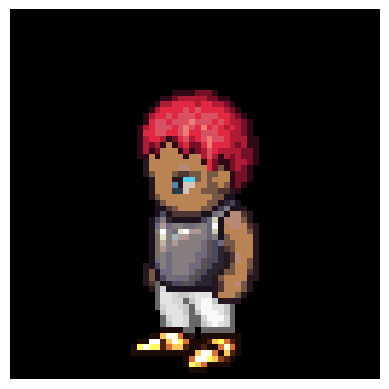

In [12]:
e = X_train[0,0,:]

plt.imshow(e)
plt.axis('off')
plt.show()

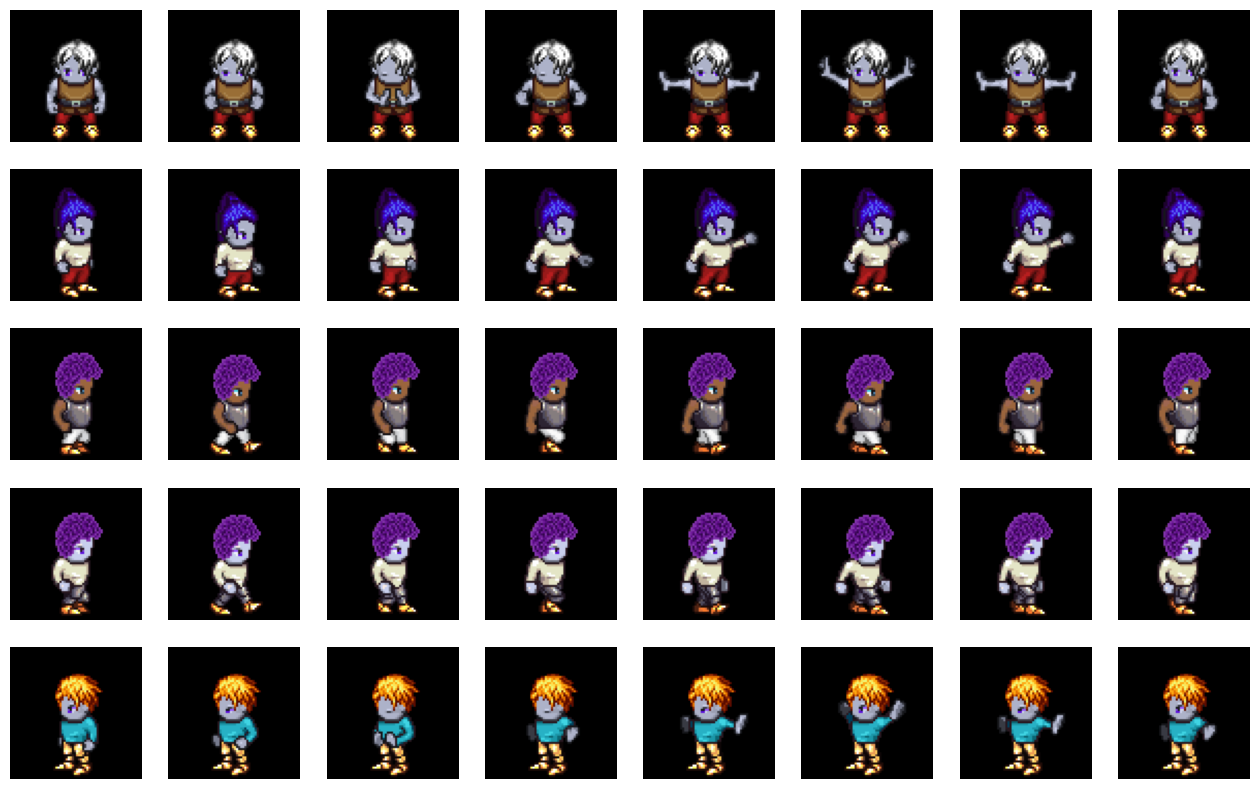

In [13]:
N = X_train.shape[0]
T = X_train.shape[1]
N_SAMPLES = 5

idx = np.random.choice(N, N_SAMPLES, replace=False)

fig, ax = plt.subplots(nrows=N_SAMPLES, ncols=T, figsize=(T*2, N_SAMPLES*2))

for i, id_seq in enumerate(idx):
    images = X_train[id_seq]
    for t in range(T):
        ax[i, t].imshow(images[t])
        ax[i, t].axis('off')

Testing PreEncoder and PostDecoder

In [14]:
# X_DIM = 8   # NB : X_DIM = 8 gives good results for the AE with the two CNNs only

X_DIM = 8 # Dimension of the observation space (exiting the CNN Encoder, inputing the VRNN and the CNN Decoder)
Z_DIM = 64 # Dimension of the latent space

In [15]:
# test PreEncoderCNN : (T,B,64,64,3) -> (T,B,Dx)

from libs.vrnn_lib_sprites import PreEncoderCNN
pre_encoder = PreEncoderCNN(Dx=X_DIM).to(device)

test_in = torch.randn(10, 5, 64, 64, 3).to(device)  # (T, B, W, H, C)
output = pre_encoder(test_in)

print(f"Shape in = {test_in.shape}")
print(f"Shape out = {output.shape}")

Shape in = torch.Size([10, 5, 64, 64, 3])
Shape out = torch.Size([10, 5, 8])


In [16]:
# test PostDecoderCNN : (T,B,Dx) -> (T,B,64,64,3)

from libs.vrnn_lib_sprites import PostDecoderCNN
post_decoder = PostDecoderCNN(Dx=X_DIM).to(device)

test_in = torch.randn(10, 5, X_DIM).to(device)  # (T, B, Dx)
output = post_decoder(test_in)

print(f"Shape in = {test_in.shape}")
print(f"Shape out = {output.shape}")  # Should be (T, B, 64, 64, 3)

Shape in = torch.Size([10, 5, 8])
Shape out = torch.Size([10, 5, 64, 64, 3])


# Dataset / Dataloader

In [17]:
# form datasets and dataloaders for PyTorch training
class CSRDataset(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]
    
train_dataset = CSRDataset(X_train)
test_dataset = CSRDataset(X_test)

In [18]:
batch_size = 512

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# VRNN Parameters

In [19]:
RNN_X_H_DIM = 128 # Dimension of the hidden state of the bidirectional LSTM network for observations
RNN_Z_H_DIM = 128 # Dimension of the hidden state of the bidirectional LSTM network for latent variables

In [20]:
vrnn = VRNN(
    input_dim = X_DIM,
    latent_dim = Z_DIM,
    rnn_x_hidden_dim = RNN_X_H_DIM,
    rnn_z_hidden_dim = RNN_Z_H_DIM,
    device=device
).to(device)

print(vrnn)

VRNN(observation_dim=8, latent_dim=64)
Bidirectional LSTM (input_size=8, rnn_x_hidden_size=128, num_layers=1)
Forward LSTM (input_size=64, rnn_z_hidden_size=128, num_layers=1)
Encoder MLP (z_dim=64, rnn_z_hidden_dim=128, rnn_x_hidden_dim=128)
Sequential(
  (0): Linear(in_features=384, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=128, bias=True)
)
Latent State Transition MLP (z_dim=64, rnn_z_hidden_dim=128, rnn_x_hidden_dim=128)
Sequential(
  (0): Linear(in_features=256, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=128, bias=True)
)
Decoder MLP (x_dim=8, rnn_z_hidden_dim=128, rnn_x_hidden_dim=128)
Sequential(
  (0): Linear(in_features=256, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(i

# Testing the pipeline

In [21]:
N = 10
# get data from dataloader
x = torch.tensor(X_train[:N, :, : ,: , :]).to(device)  # (B, T, W, H, C)
print(f"Shape of input out of X_train (batch {N} samples) = {x.shape}")

# get the right shape
x2 = x.permute(1,0,2,3,4)  # (T, B, W, H, C)
print(f"Shape of input after permute = {x2.shape}")

# preencode
x3 = pre_encoder(x2)  # (T, B, Dx)
print(f"Shape of input after preencoding = {x3.shape}")

# go through the VRNN
x_t, mu_x_t, logvar_x_t, mu_phi_z_t, logvar_phi_z_t, mu_theta_z_t, logvar_theta_z_t = vrnn(x3)  # mu_x_t (T,B,Dx), logvar_x_t (T,B,Dx)
print(f"Shape of input after VRNN : mu_x_t = {mu_x_t.shape}, logvar_x_t = {logvar_x_t.shape}")

# sample some x with Dx
sampled_xs = mu_x_t + torch.randn_like(mu_x_t) * torch.exp(0.5 * logvar_x_t)  # (T, B, Dx)
print(f"Shape of sampled x = {sampled_xs.shape}")

# decode the sampled x into images
x_hat = post_decoder(sampled_xs)  # (T, B, 64, 64, 3)
print(f"Shape of decoded x_hat = {x_hat.shape}")

# get the original shape back
x_hat = x_hat.permute(1, 0, 2, 3, 4)  # (B, T, W, H, C)
print(f"Shape of x_hat after permute = {x_hat.shape}")

# loss
loss = (x - x_hat).pow(2).sum(dim=(2, 3, 4))  # (T, B)
loss = loss.mean(dim=(0, 1))  # (,)
print(f"Shape of loss = {loss.shape}, Loss value = {loss.item()}")

Shape of input out of X_train (batch 10 samples) = torch.Size([10, 8, 64, 64, 3])
Shape of input after permute = torch.Size([8, 10, 64, 64, 3])
Shape of input after preencoding = torch.Size([8, 10, 8])
Shape of input after VRNN : mu_x_t = torch.Size([8, 10, 8]), logvar_x_t = torch.Size([8, 10, 8])
Shape of sampled x = torch.Size([8, 10, 8])
Shape of decoded x_hat = torch.Size([8, 10, 64, 64, 3])
Shape of x_hat after permute = torch.Size([10, 8, 64, 64, 3])
Shape of loss = torch.Size([]), Loss value = 2522.288330078125


# Training loop

In [22]:
# One Training Step
def train_step(pre_encoder, vrnn, postdecoder, train_loader, learning_rate, criterion, optimizer, beta=None):
    """Perform one training step on the chain of models:
    - get batch data
    - go through preencoder
    - go through vrnn
    - go through postdecoder
    - compute loss
    - backpropagate and update weights
    """
    
    # training mode
    pre_encoder.train()
    vrnn.train()
    post_decoder.train()
    
    # training loop
    rec_vrnn_epoch_loss = 0.0
    kl_epoch_loss = 0.0
    rec_cnn_epoch_loss = 0.0
    total_epoch_loss = 0.0
    
    for x_batch in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        x_batch = x_batch.to(device)  # Move batch to device
        # run the pipeline
        x_encoded = pre_encoder(x_batch.permute(1, 0, 2, 3, 4).to(device))  # (T, B, Dx)
        x_t, mu_x_t, logvar_x_t, mu_phi_z_t, logvar_phi_z_t, mu_theta_z_t, logvar_theta_z_t = vrnn(x_encoded)  # mu_x_t (T,B,Dx), logvar_x_t (T,B,Dx)
        sampled_xs = mu_x_t + torch.randn_like(mu_x_t) * torch.exp(0.5 * logvar_x_t)  # (T, B, Dx)
        x_hat = post_decoder(sampled_xs)  # (T, B, 64, 64, 3)
        # x_hat = post_decoder(x_encoded)  # (T, B, 64, 64, 3)  ND - AE SEULEMENT !!
        x_hat = x_hat.permute(1, 0, 2, 3, 4)  # (B, T, W, H, C)
        # compute the loss
        rec_loss_vrnn_batch, kl_batch, total_vrnn_loss_batch = loss_function(x_t, mu_x_t, logvar_x_t, mu_phi_z_t, logvar_phi_z_t, mu_theta_z_t, logvar_theta_z_t, beta=beta)
        # kl = torch.tensor(0.0)  # Placeholder for KL divergence, in case we train AE only
        # compute L2 loss on images
        rec_cnn_batch = (x_batch - x_hat).pow(2).sum(dim=(2, 3, 4))   # (T, B)
        rec_cnn_batch = rec_cnn_batch.mean(dim=(0, 1)) # (,)
        # compute the total loss
        total_loss_batch = total_vrnn_loss_batch + rec_cnn_batch
        # backpropagation
        total_loss_batch.backward()  # Backward pass
        optimizer.step()  # Update weights
        # sum over batch
        rec_vrnn_epoch_loss += rec_loss_vrnn_batch.item()
        kl_epoch_loss += kl_batch.item()
        rec_cnn_epoch_loss += rec_cnn_batch.item()
        total_epoch_loss += total_loss_batch.item()
        print(f"(Training) - Batch Loss: {total_loss_batch.item():.4f}, Rec Loss VRNN: {rec_loss_vrnn_batch.item():.4f}, KL Loss: {kl_batch.item():.4f}, Rec Loss CNNs: {rec_cnn_batch.item():.4f}", end='\r')
    
    # Average the losses over the entire epoch
    rec_vrnn_epoch_loss /= len(train_loader)
    kl_epoch_loss /= len(train_loader)
    rec_cnn_epoch_loss /= len(train_loader)
    total_epoch_loss /= len(train_loader)
        
    return pre_encoder, vrnn, post_decoder, rec_vrnn_epoch_loss, kl_epoch_loss, rec_cnn_epoch_loss, total_epoch_loss

In [23]:
# One Test Step
def test_step(pre_encoder, vrnn, postdecoder, test_loader):
    """Perform one test step on the chain of models."""
    
    # mode evaluation
    pre_encoder.eval()
    vrnn.eval()
    post_decoder.eval()
    
    # testing loop
    rec_vrnn_epoch_loss = 0.0
    kl_epoch_loss = 0.0
    rec_cnn_epoch_loss = 0.0
    total_epoch_loss = 0.0
    
    with torch.no_grad():
        for x_batch in test_loader:
            
            x_batch = x_batch.to(device)  # Move batch to device
            # run the pipeline
            x_encoded = pre_encoder(x_batch.permute(1, 0, 2, 3, 4).to(device))  # (T, B, Dx)
            x_t, mu_x_t, logvar_x_t, mu_phi_z_t, logvar_phi_z_t, mu_theta_z_t, logvar_theta_z_t = vrnn(x_encoded)  # mu_x_t (T,B,Dx), logvar_x_t (T,B,Dx)
            sampled_xs = mu_x_t + torch.randn_like(mu_x_t) * torch.exp(0.5 * logvar_x_t)  # (T, B, Dx)
            x_hat = post_decoder(sampled_xs)  # (T, B, 64, 64, 3)
            # x_hat = post_decoder(x_encoded)  # (T, B, 64, 64, 3)  ND - AE SEULEMENT !!
            x_hat = x_hat.permute(1, 0, 2, 3, 4)  # (B, T, W, H, C)
            # compute the loss
            rec_loss_vrnn_batch, kl_batch, total_vrnn_loss_batch = loss_function(x_t, mu_x_t, logvar_x_t, mu_phi_z_t, logvar_phi_z_t, mu_theta_z_t, logvar_theta_z_t)
            # kl = torch.tensor(0.0)  # Placeholder for KL divergence, as we are not using it in AE only
            rec_cnn_batch = (x_batch - x_hat).pow(2).sum(dim=(2, 3, 4))   # (T, B)
            rec_cnn_batch = rec_cnn_batch.mean(dim=(0, 1)) # (,)
            total_loss_batch = total_vrnn_loss_batch + rec_cnn_batch
            # sum over batch
            rec_vrnn_epoch_loss += rec_loss_vrnn_batch.item()
            kl_epoch_loss += kl_batch.item()
            rec_cnn_epoch_loss += rec_cnn_batch.item()
            total_epoch_loss += total_loss_batch.item()
            print(f"(Validation) - Batch Loss: {total_loss_batch.item():.4f}, Rec Loss VRNN: {rec_loss_vrnn_batch.item():.4f}, KL Loss: {kl_batch.item():.4f}, Rec Loss CNNs: {rec_cnn_batch.item():.4f}", end='\r')
            
    # Average the losses over the entire epoch
    rec_vrnn_epoch_loss /= len(test_loader)
    kl_epoch_loss /= len(test_loader)
    rec_cnn_epoch_loss /= len(test_loader)
    total_epoch_loss /= len(test_loader)
    
    return rec_vrnn_epoch_loss, kl_epoch_loss, rec_cnn_epoch_loss, total_epoch_loss

In [24]:
pre_encoder = PreEncoderCNN(Dx=X_DIM).to(device)
post_decoder = PostDecoderCNN(Dx=X_DIM).to(device)
vrnn = VRNN(
    input_dim = X_DIM,
    latent_dim = Z_DIM,
    rnn_x_hidden_dim = RNN_X_H_DIM,
    rnn_z_hidden_dim = RNN_Z_H_DIM,
    device=device
).to(device)

# optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(list(pre_encoder.parameters()) + list(vrnn.parameters()) + list(post_decoder.parameters()), lr=learning_rate)

# loss
criterion = loss_function

In [25]:
# Early stopping class to prevent overfitting

class EarlyStoppingCallback:
    def __init__(self, patience=1, min_delta=0):
        # how many epochs do we accept with validation loss non decreasing
        self.patience = patience
        # tolerance for non decrease
        self.min_delta = min_delta
        # how many epochs without validation loss decrease
        self.counter = 0
        # minimum validation loss to beat
        self.min_validation_loss = float('inf')
        self.status = False

    def early_stop(self, validation_loss):
        # is the last validation loss better than the current minimum ?
        # status = True means stop training
        if validation_loss < self.min_validation_loss:
            # yes : update minimum value and reset counter
            self.min_validation_loss = validation_loss
            self.counter = 0
            self.status = False
            # no : are we within tolerance ?
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            # no : increase counter (losing patience)
            self.counter += 1
            # have we lost patience ?
            if self.counter >= self.patience:
                # yes
                self.status = True
            else:
                # no
                self.status = False

        return self.status, self.counter

patience = 50
early_stopper = EarlyStoppingCallback(patience, min_delta=1e-2)

In [26]:
# Prepare for training

if device.type == 'cuda':
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = round(torch.cuda.get_device_properties(0).total_memory/1024**3,1)
    print(f"Using GPU: {gpu_name} with {gpu_memory} GB memory")
    
n_epochs = 5000
display_interval = 10  # How often to display images
T = X_train.shape[1]  # Number of time steps in the sequences
stop = False

# record train losses
train_losses = []
train_rec_vrnn_losses = []
train_rec_cnn_losses = []
train_kl_losses = []
# record test losses
test_losses = []
test_rec_vrnn_losses = []
test_rec_cnn_losses = []
test_kl_losses = []
# betas
betas = []

# beta management
beta = 0.0
beta_scheduler = BetaLinearScheduler(
    beta_start=0.0, epoch_start=0,
    beta_end=1.0, num_epochs=10
)
train_rec_vrnn_loss = 1.0

print(f'Summary: Dx={X_DIM}, Dz={Z_DIM}, RNN_X_H_DIM={RNN_X_H_DIM}, RNN_Z_H_DIM={RNN_Z_H_DIM}, N_EPOCHS={n_epochs}, BATCH_SIZE={batch_size}')
print(f'Learning rate: {learning_rate:.3e}, Patience: {patience}, Device: {device}')
print(f'Beta scheduler: {beta_scheduler.__class__.__name__}, Initial beta: {beta_scheduler.beta_start}, Final beta: {beta_scheduler.beta_end} with {beta_scheduler.num_epochs} epochs')

Using GPU: NVIDIA GeForce RTX 3090 with 23.7 GB memory
Summary: Dx=8, Dz=64, RNN_X_H_DIM=128, RNN_Z_H_DIM=128, N_EPOCHS=5000, BATCH_SIZE=512
Learning rate: 1.000e-03, Patience: 50, Device: cuda
Beta scheduler: BetaLinearScheduler, Initial beta: 0.0, Final beta: 1.0 with 10 epochs


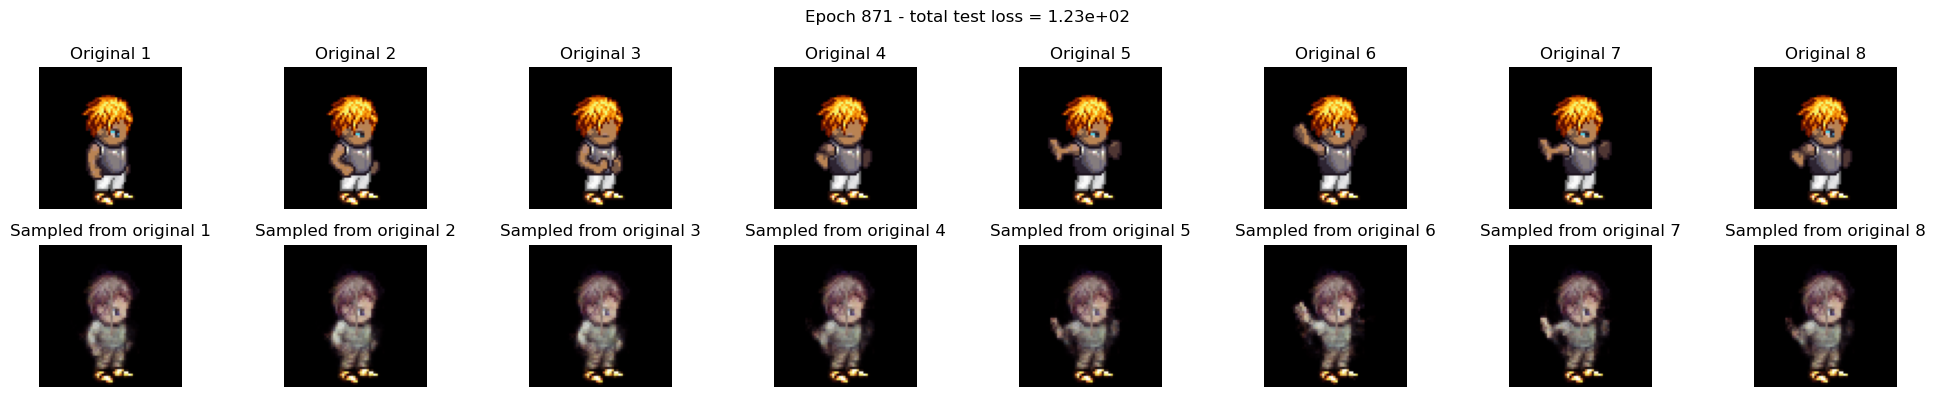

Epoch [872    .../... 5000  ] beta = 1.00 -- TRAIN : (Total) 1.2346e+02 (Rec VRNN) -3.0858e+01 (KL) 1.1129e+00 (Rec CNN) 1.5321e+02 -- TEST : (Total) 1.2255e+02 (Rec VRNN) -3.0865e+01 (KL) 1.1101e+00 (Rec CNN) 1.5231e+02 -- Early stopping counter: 47 / 50
Epoch [873    .../... 5000  ] beta = 1.00 -- TRAIN : (Total) 1.2303e+02 (Rec VRNN) -3.0945e+01 (KL) 1.1085e+00 (Rec CNN) 1.5286e+02 -- TEST : (Total) 1.2228e+02 (Rec VRNN) -3.0890e+01 (KL) 1.1067e+00 (Rec CNN) 1.5206e+02 -- Early stopping counter: 48 / 50
Epoch [874    .../... 5000  ] beta = 1.00 -- TRAIN : (Total) 1.2286e+02 (Rec VRNN) -3.1024e+01 (KL) 1.1031e+00 (Rec CNN) 1.5278e+02 -- TEST : (Total) 1.2210e+02 (Rec VRNN) -3.1040e+01 (KL) 1.1059e+00 (Rec CNN) 1.5204e+02 -- Early stopping counter: 49 / 50
Epoch [875    .../... 5000  ] beta = 1.00 -- TRAIN : (Total) 1.2227e+02 (Rec VRNN) -3.1103e+01 (KL) 1.1001e+00 (Rec CNN) 1.5227e+02 -- TEST : (Total) 1.2266e+02 (Rec VRNN) -3.1056e+01 (KL) 1.0994e+00 (Rec CNN) 1.5262e+02 -- Early st

In [80]:
# Training !!

# start the clock
start = timeit.default_timer()

if beta_scheduler is not None:
    print(f"Beta scheduler: {beta_scheduler}")
else:
    print(f"Beta scheduler: None, beta = {beta:.3e}")

for epoch in range(n_epochs):
    
    # use the beat scheduler if provided
    if beta_scheduler is not None:
        beta = beta_scheduler(epoch, train_rec_vrnn_loss)
    betas.append(beta)
    
    # training and testing steps
    pre_encoder, vrnn, post_decoder, train_rec_vrnn_loss, train_kl_loss, train_rec_cnn_loss, total_train_loss = train_step(
        pre_encoder, vrnn, post_decoder, 
        train_loader, 
        learning_rate, criterion, optimizer, 
        beta=beta
    )
    test_rec_vrnn_loss, test_kl_loss, test_rec_cnn_loss, total_test_loss = test_step(pre_encoder, vrnn, post_decoder, test_loader)
    
    # log train losses
    train_losses.append(total_train_loss)
    train_rec_vrnn_losses.append(train_rec_vrnn_loss)
    train_rec_cnn_losses.append(train_rec_cnn_loss)
    train_kl_losses.append(train_kl_loss)

    # log test losses
    test_losses.append(total_test_loss)
    test_rec_vrnn_losses.append(test_rec_vrnn_loss)
    test_rec_cnn_losses.append(test_rec_cnn_loss)
    test_kl_losses.append(test_kl_loss)
    
    # Early stopping check
    if early_stopper:
        stop, counter = early_stopper.early_stop(total_test_loss)
        if stop:
            msg = f'Early stopping at epoch {epoch+1} with counter {counter}'
            stop = True
        else:
            msg = f'Early stopping counter: {counter} / {early_stopper.patience}'
    
    # reporting        
    print(f'Epoch [{epoch+1:<6} .../... {n_epochs:<6}] beta = {beta:.2f} -- ' + \
        f'TRAIN : (Total) {total_train_loss:.4e} (Rec VRNN) {train_rec_vrnn_loss:.4e} (KL) {train_kl_loss:.4e} (Rec CNN) {train_rec_cnn_loss:.4e} -- ' +\
        f'TEST : (Total) {total_test_loss:.4e} (Rec VRNN) {test_rec_vrnn_loss:.4e} (KL) {test_kl_loss:.4e} (Rec CNN) {test_rec_cnn_loss:.4e} ' +\
        f'-- {msg}'
    )
    
    if stop:
        print("Early stopping triggered. Stopping training.")
        break
    
    # check images every NN epochs
    if (epoch) % display_interval == 0:
        # make room
        clear_output(wait=True)
        with torch.no_grad():
            # get one sequence of images from the test set
            idx = np.random.choice(X_test.shape[0], 1, replace=False)
            image = torch.tensor(X_test[idx]).to(device)  # (1, T, W, H, C)
            img_encoded = pre_encoder(image.permute(1, 0, 2, 3, 4).to(device)) # (T, B, Dx)
            x_t, mu_x_t, logvar_x_t, mu_phi_z_t, logvar_phi_z_t, mu_theta_z_t, logvar_theta_z_t = vrnn(img_encoded)  # mu_x_t (T,B,Dx), logvar_x_t (T,B,Dx)
            sampled_xs = mu_x_t + torch.randn_like(mu_x_t) * torch.exp(0.5 * logvar_x_t)  # (T, B, Dx)
            x_hat = post_decoder(sampled_xs)  # (T, B, 64, 64, 3)
            x_hat = x_hat.permute(1, 0, 2, 3, 4)  # (B, T, W, H, C)
            # plot 
            fig, ax = plt.subplots(nrows=2, ncols=T, figsize=(20, 2 * 2))
            for j in range(X_test.shape[1]):
                # Original images
                ax[0,j].imshow(image[0, j].cpu().numpy())
                ax[0,j].axis('off')
                ax[0,j].set_title(f'Original {j+1}')
                # Reconstructed images
                ax[1,j].imshow(x_hat[0, j].detach().cpu().numpy())
                ax[1,j].axis('off')
                ax[1,j].set_title(f'Sampled from original {j+1}')
            fig.suptitle(f'Epoch {epoch+1} - total test loss = {total_test_loss:.2e}', fontsize=12)
            plt.tight_layout()
            plt.show()
    
end = timeit.default_timer()

print(f"Trained {n_epochs} epochs in {end - start:.2f} seconds on {gpu_name} with {gpu_memory} GB memory")

# Save models

In [ ]:
path = 'models/'
# Save models
# torch.save(pre_encoder.state_dict(), path + 'pre_encoder.pth')
# torch.save(vrnn.state_dict(), path + 'vrnn.pth')
# torch.save(post_decoder.state_dict(), path + 'post_decoder.pth')

# Plot losses

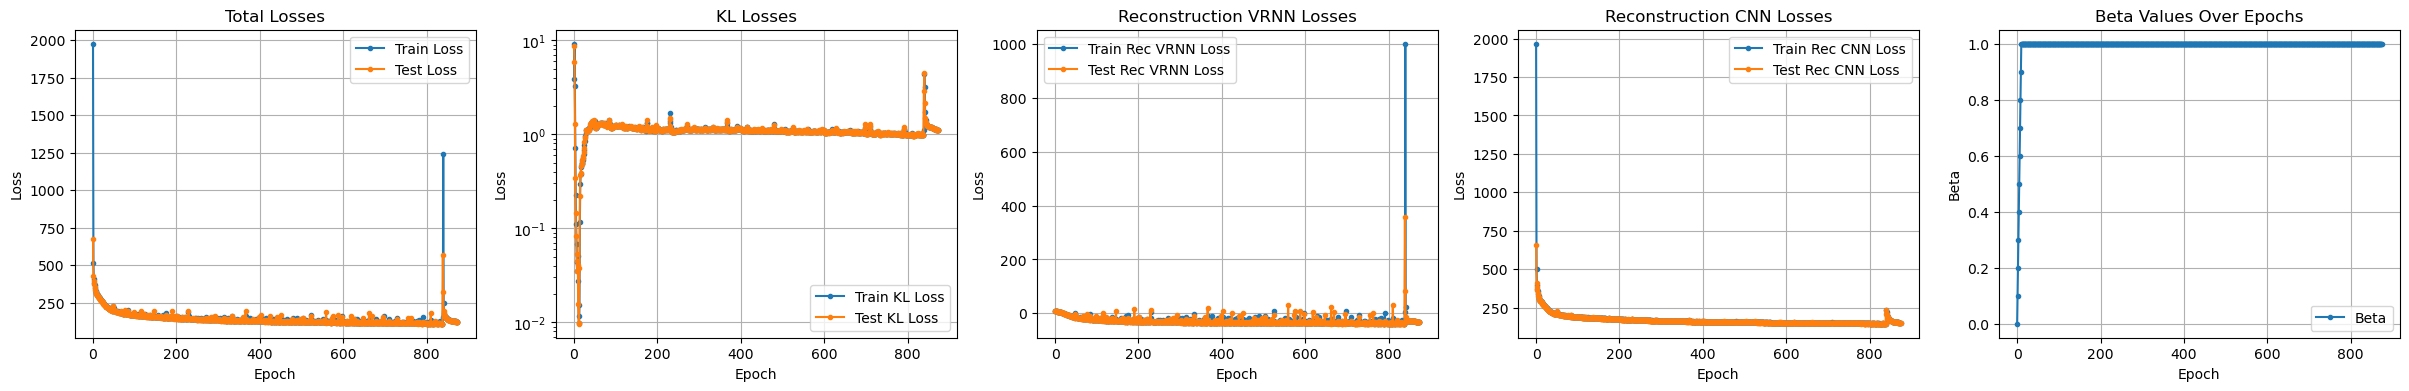

In [81]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(30, 4))

# plot total losses
ax[0].plot(train_losses, label='Train Loss', marker='.')
ax[0].plot(test_losses, label='Test Loss', marker='.')
ax[0].set_title('Total Losses')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True)

# plot kl losses
ax[1].plot(train_kl_losses, label='Train KL Loss', marker='.')
ax[1].plot(test_kl_losses, label='Test KL Loss', marker='.')
ax[1].set_title('KL Losses')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')   
ax[1].set_yscale('log')  # Log scale for better visibility 
ax[1].legend()
ax[1].grid(True)

# plot reconstruction losses VRNN
ax[2].plot(train_rec_vrnn_losses, label='Train Rec VRNN Loss', marker='.')
ax[2].plot(test_rec_vrnn_losses, label='Test Rec VRNN Loss', marker='.')
ax[2].set_title('Reconstruction VRNN Losses')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
ax[2].grid(True)

# plot reconstrcution losses CNN
ax[3].plot(train_rec_cnn_losses, label='Train Rec CNN Loss', marker='.')
ax[3].plot(test_rec_cnn_losses, label='Test Rec CNN Loss', marker='.')
ax[3].set_title('Reconstruction CNN Losses')
ax[3].set_xlabel('Epoch')
ax[3].set_ylabel('Loss')
ax[3].legend()
ax[3].grid(True)

# plot betas
ax[4].plot(betas, label='Beta', marker='.')
ax[4].set_title('Beta Values Over Epochs')
ax[4].set_xlabel('Epoch')
ax[4].set_ylabel('Beta')
ax[4].legend()
ax[4].grid(True)   

# Load models

In [27]:
path = 'models/'

pre_encoder = PreEncoderCNN(Dx=X_DIM).to(device)
post_decoder = PostDecoderCNN(Dx=X_DIM).to(device)
vrnn = VRNN(
    input_dim = X_DIM,
    latent_dim = Z_DIM,
    rnn_x_hidden_dim = RNN_X_H_DIM,
    rnn_z_hidden_dim = RNN_Z_H_DIM,
    device=device
).to(device)

# Load models
pre_encoder.load_state_dict(torch.load(path + 'pre_encoder.pth', map_location=device))
vrnn.load_state_dict(torch.load(path + 'vrnn.pth', map_location=device))
post_decoder.load_state_dict(torch.load(path + 'post_decoder.pth', map_location=device))
# torch.save(pre_encoder.state_dict(), path + 'pre_encoder.pth')
# torch.save(vrnn.state_dict(), path + 'vrnn.pth')
# torch.save(post_decoder.state_dict(), path + 'post_decoder.pth')

/tmp/ipykernel_1390010/2301829316.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pre_encoder.load_state_dict(torch.load(path + 'pre_encoder.pth', map_location=device))

<All keys matched successfully>

# Some visualisation - reconstruction

In [28]:
N_SAMPLES = 5

idx = np.random.choice(X_test.shape[0], N_SAMPLES, replace=False)

images = torch.tensor(X_test[idx]).to(device)

x_encoded = pre_encoder(images.permute(1, 0, 2, 3, 4).to(device))  # (T, B, Dx)
x_t, mu_x_t, logvar_x_t, mu_phi_z_t, logvar_phi_z_t, mu_theta_z_t, logvar_theta_z_t = vrnn(x_encoded)  # mu_x_t (T,B,Dx), logvar_x_t (T,B,Dx)
sampled_xs = mu_x_t + torch.randn_like(mu_x_t) * torch.exp(0.5 * logvar_x_t)  # (T, B, Dx)
x_hat = post_decoder(sampled_xs)  # (T, B, 64, 64, 3)
# x_hat = post_decoder(x_encoded)  # (T, B, 64, 64, 3)  ND - AE SEULEMENT !!
x_hat = x_hat.permute(1, 0, 2, 3, 4)  # (B, T, W, H, C)

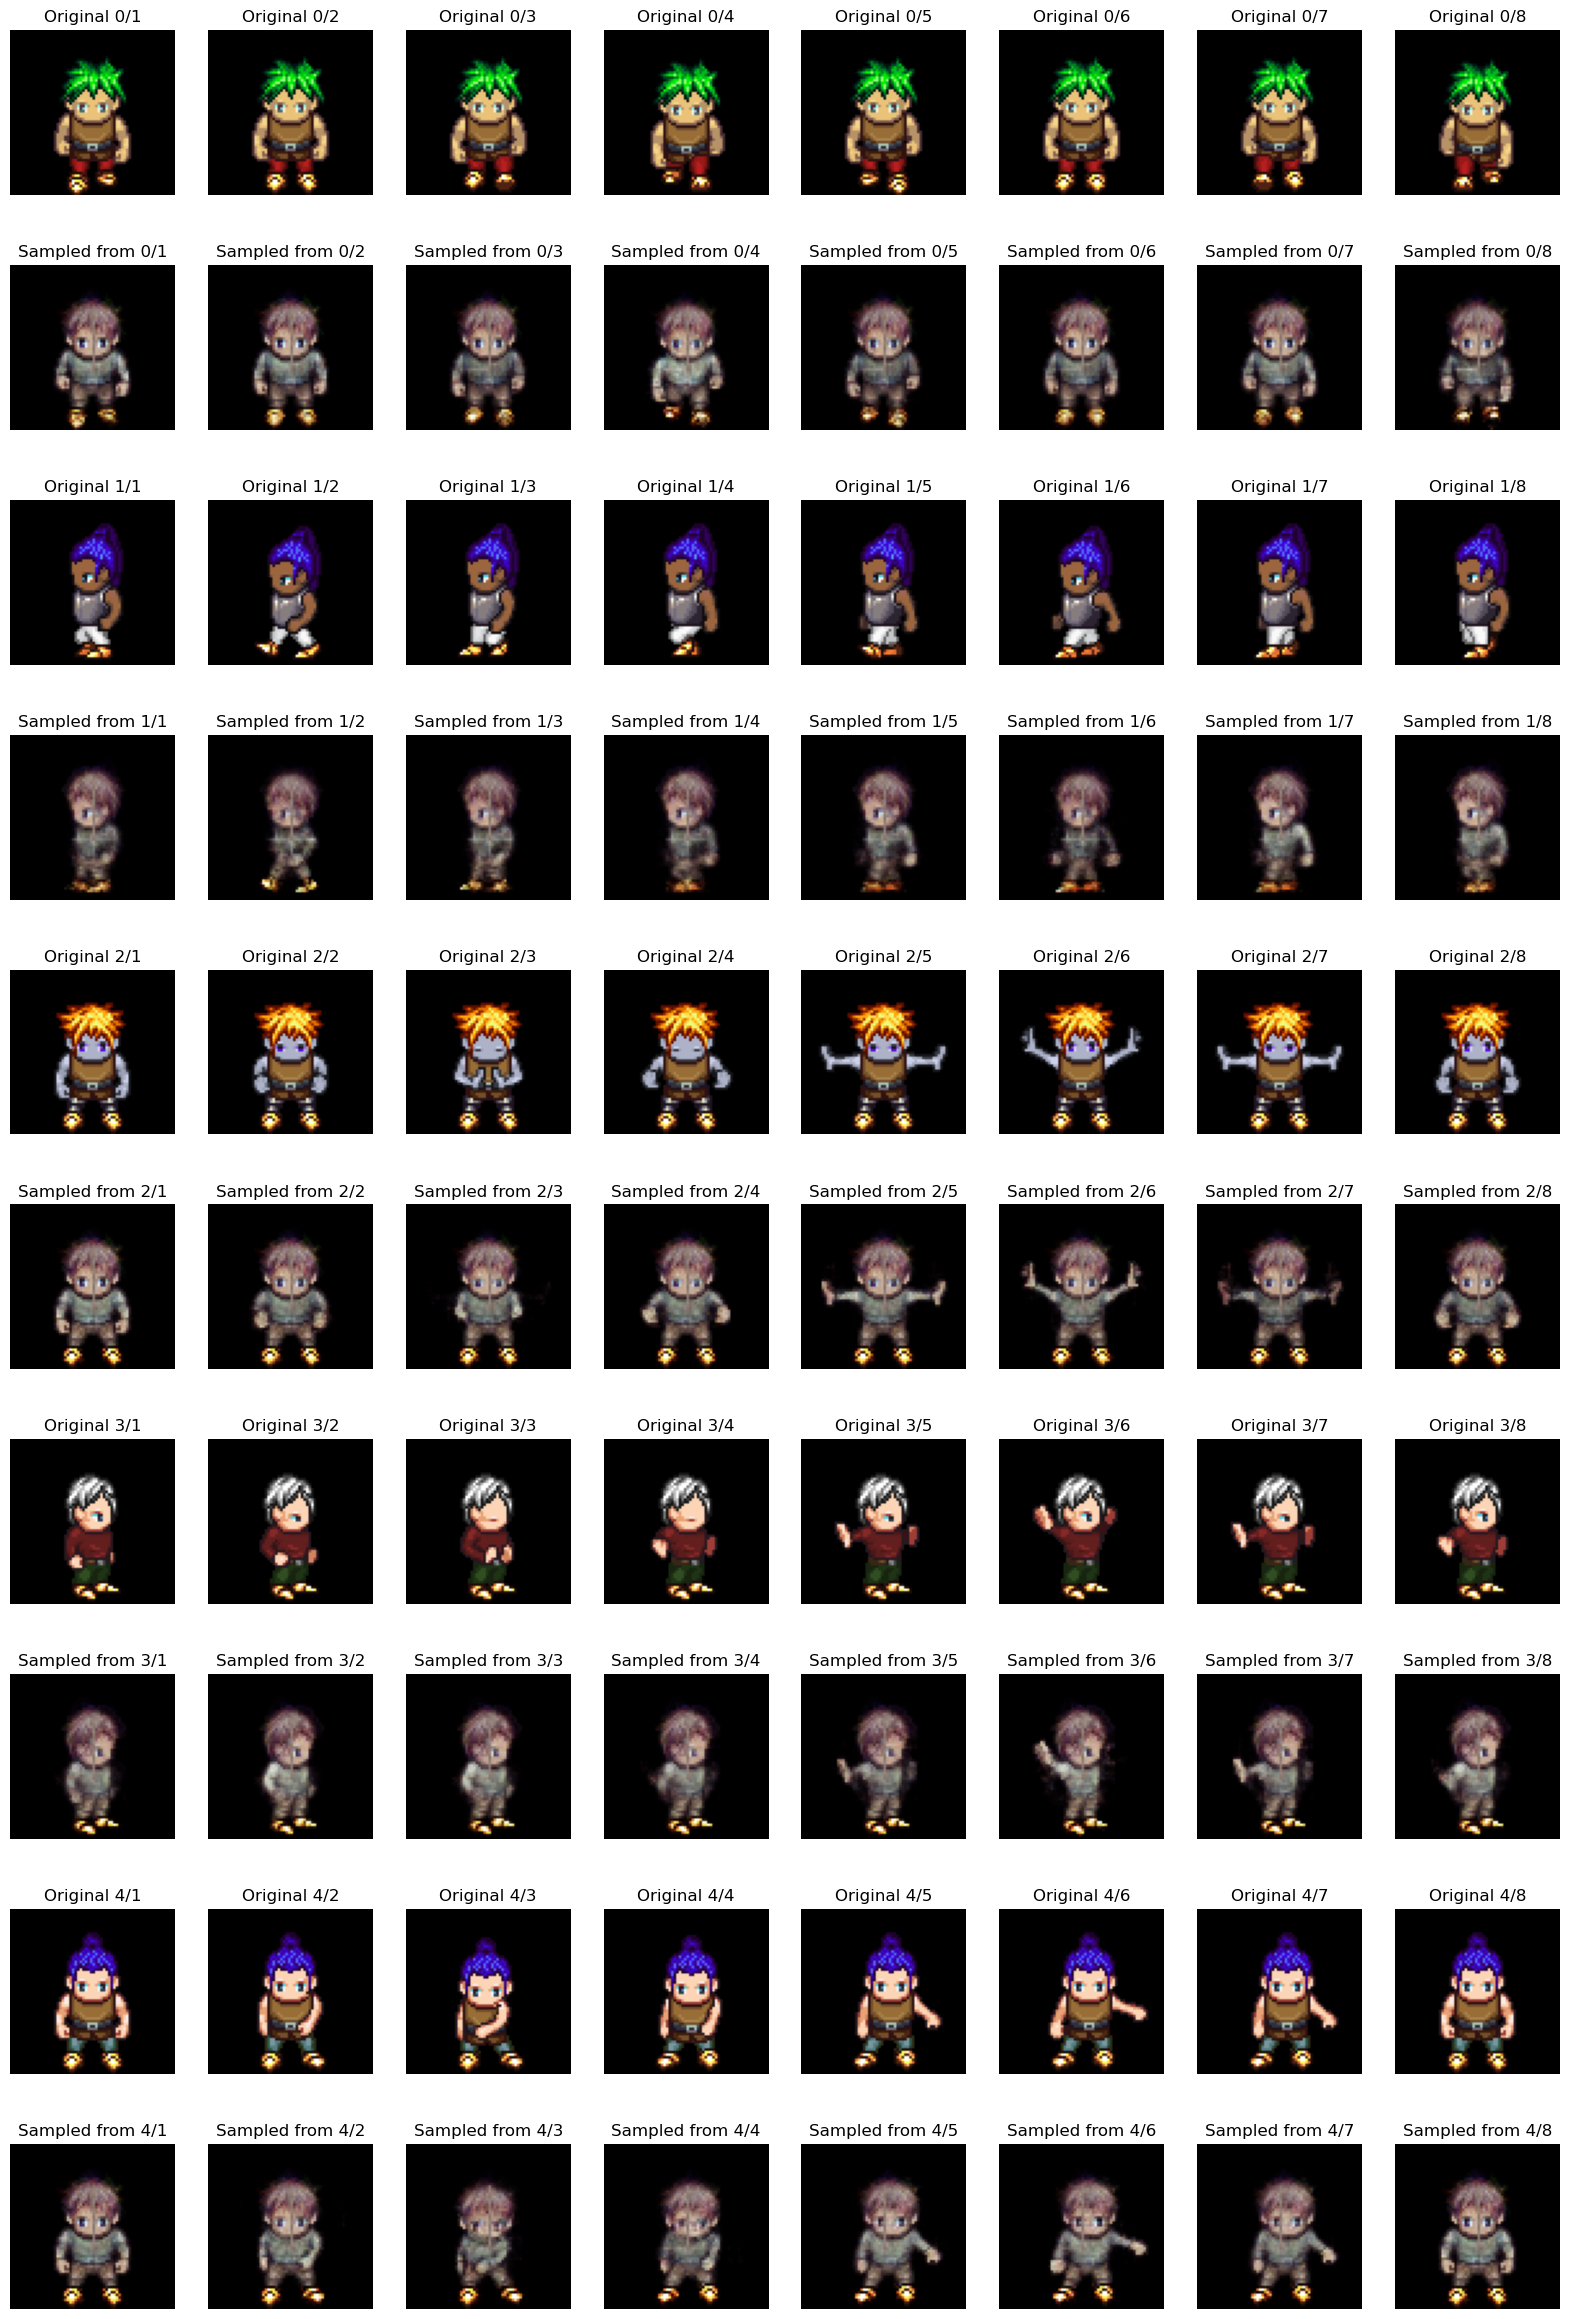

In [29]:
T = x_hat.shape[1]  # Number of time steps
fig, ax = plt.subplots(nrows=2*N_SAMPLES, ncols=T, figsize=(20, 6 * N_SAMPLES))
for i, id_seq in enumerate(idx):

    for j in range(X_test.shape[1]):
        # Original images
        ax[2*i, j].imshow(images[i, j].cpu().numpy())
        ax[2*i, j].axis('off')
        ax[2*i, j].set_title(f'Original {i}/{j+1}')
        
        # Reconstructed images
        ax[2*i+1, j].imshow(x_hat[i, j].detach().cpu().numpy())
        ax[2*i+1, j].axis('off')
        ax[2*i+1, j].set_title(f'Sampled from {i}/{j+1}')

# Generation

In [40]:
N_SAMPLES = 5
SEQ_LEN = 20

# Get the first image of N_SAMPLES random sequences
idx = np.random.choice(X_test.shape[0], N_SAMPLES, replace=False)
images = torch.tensor(X_test[idx,0,:,:,:]).unsqueeze(1).to(device)

# Generate sequences
images_ = images.permute(1, 0, 2, 3, 4)  # (T=1, B, W, H, C)
images_encoded = pre_encoder(images_)  # (T=1, B, Dx)
mu_x_pred, logvar_x_pred, _, _ = vrnn.predict(images_encoded, num_steps=SEQ_LEN)  # (T_pred, B, Dx)
sampled_xs = mu_x_pred + torch.randn_like(mu_x_pred) * torch.exp(0.5 * logvar_x_pred)  # (T_pred, B, Dx)
x_hat = post_decoder(sampled_xs)  # (T_pred, B, 64, 64, 3)
x_hat = x_hat.permute(1, 0, 2, 3, 4)  # (B, T_pred, W, H, C)

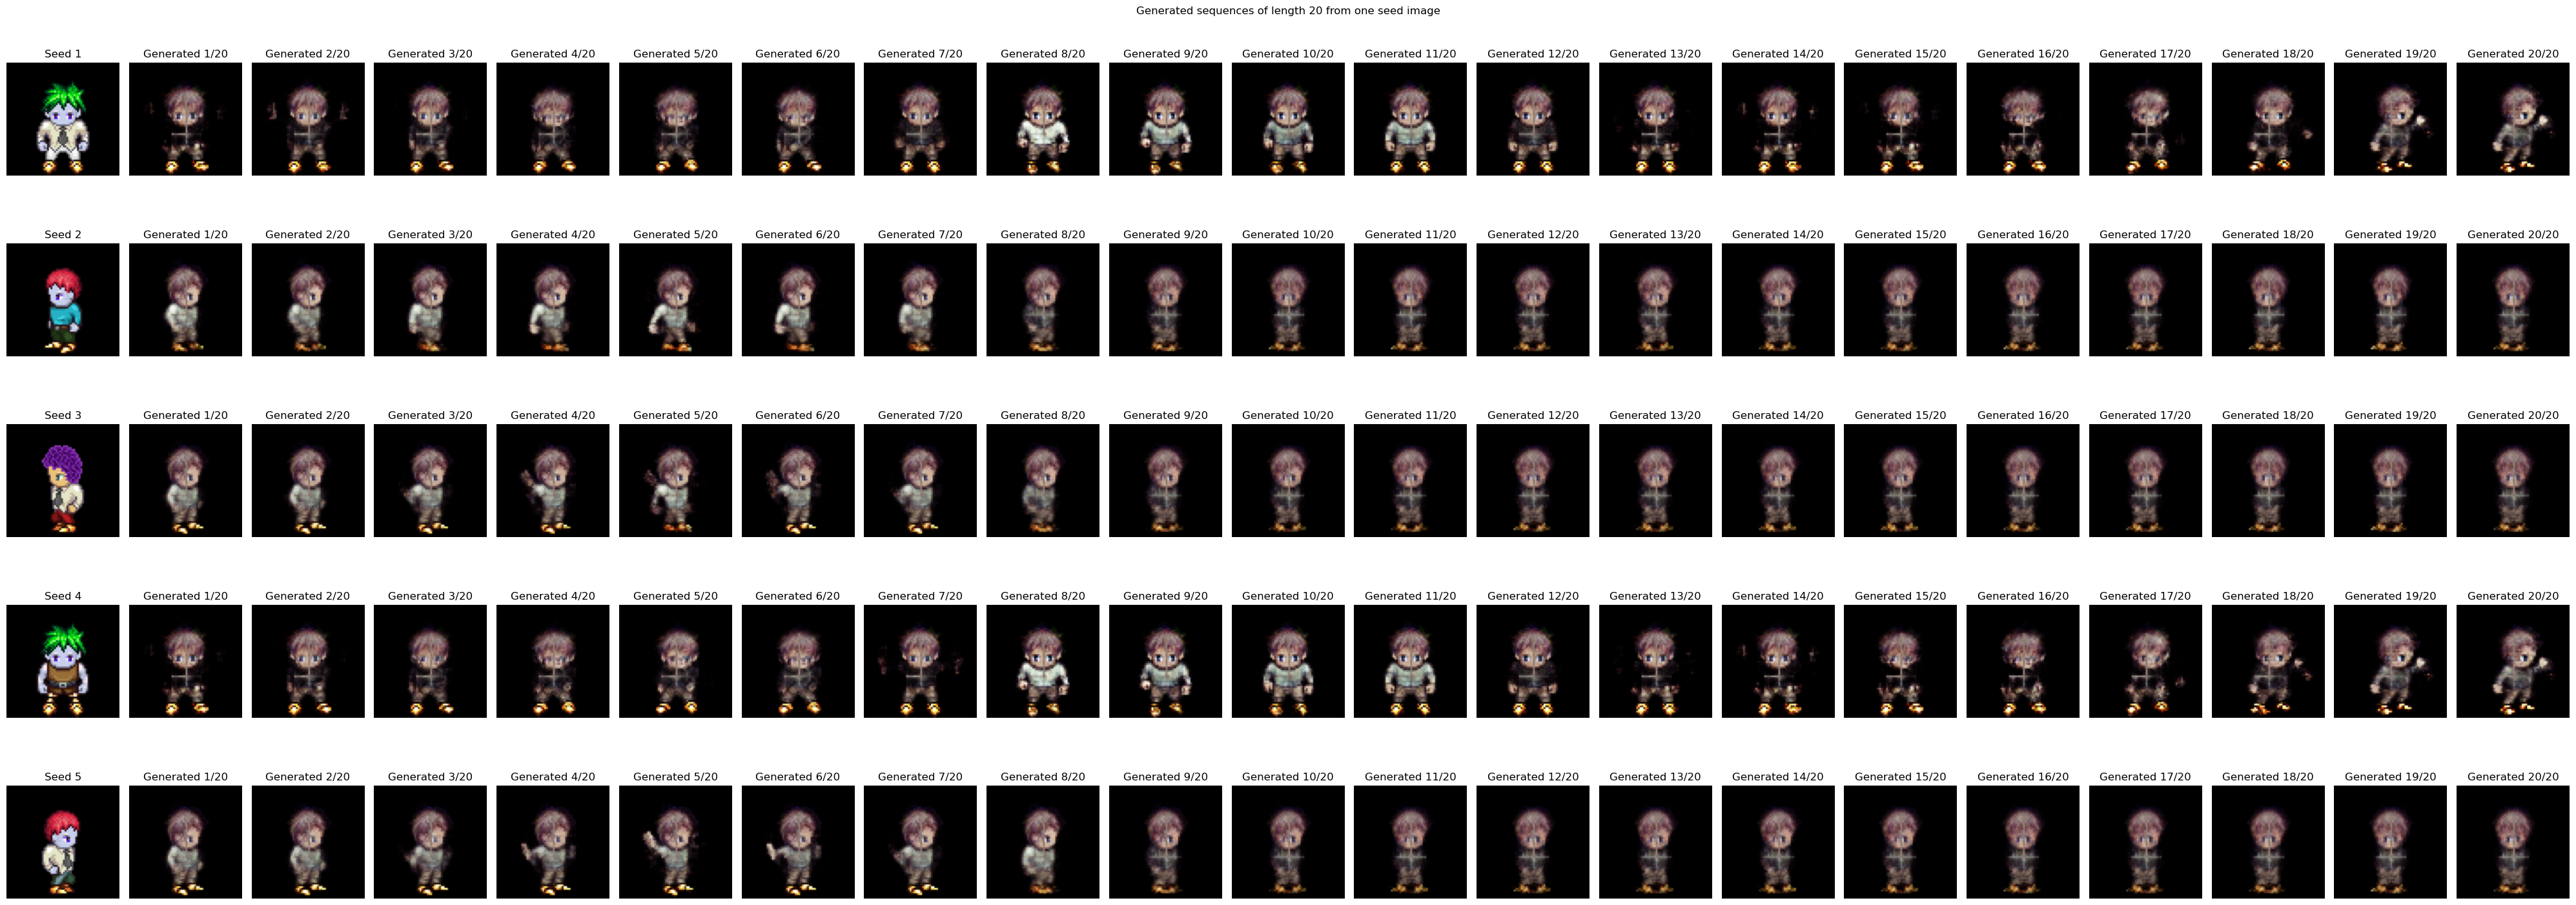

In [41]:
fig, ax = plt.subplots(nrows=N_SAMPLES, ncols=SEQ_LEN+1, figsize=(SEQ_LEN*2, N_SAMPLES*3)) # width, height

for i in range(N_SAMPLES):
    # First column: original first image
    ax[i, 0].imshow(images[i, 0].cpu().numpy())
    ax[i, 0].axis('off')
    ax[i, 0].set_title(f'Seed {i+1}')
    
    for j in range(SEQ_LEN):
        # Subsequent columns: generated images
        ax[i, j+1].imshow(x_hat[i, j].detach().cpu().numpy())
        ax[i, j+1].axis('off')
        ax[i, j+1].set_title(f'Generated {j+1}/{SEQ_LEN}')
        
fig.suptitle(f'Generated sequences of length {SEQ_LEN} from one seed image', fontsize=12)
plt.tight_layout() 
plt.show()